In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.chdir('../')

In [2]:
from txt2img_latent import get_parser, load_model_from_config, chunk

parser = get_parser()

# 2) args_list 정의 (원하는 인자들을 문자열 리스트로)
args_list = [
    "--config", "configs/stable-diffusion/v1-inference.yaml",
    "--ckpt", "models/ldm/stable-diffusion-v1/sd-v1-4.ckpt",
    "--H", "512",
    "--W", "512",
    "--C", "4",
    "--f", "8",
]

# 3) parse_args() 실행
opt = parser.parse_args(args_list)

/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-18 11:54:36.401060: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 11:54:36.465805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 11:54:36.465831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 11:54:36

['/home/logpx/miniconda3/envs/rbf/lib/python311.zip', '/home/logpx/miniconda3/envs/rbf/lib/python3.11', '/home/logpx/miniconda3/envs/rbf/lib/python3.11/lib-dynload', '', '/home/logpx/.local/lib/python3.11/site-packages', '/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages', '/home/logpx/scpark/dpm-solver-v32/codebases/stable-diffusion/src/taming-transformers', '/home/logpx/scpark/dpm-solver-v32/codebases/stable-diffusion/src/clip', '/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages/setuptools/_vendor', '/tmp/tmptx7g6275']


In [ ]:
import torch
from omegaconf import OmegaConf

config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
print('done')

Loading model from models/ldm/stable-diffusion-v1/sd-v1-4.ckpt


In [ ]:
from ldm.models.diffusion.rbf import RBFSampler
from ldm.models.diffusion.uni_pc import UniPCSampler

#sampler = UniPCSampler(model)
sampler = RBFSampler(model)
print('done')

done


In [ ]:
N = 128
M = 6
SCALE = 1.5

!mkdir -p /data/ldm/scale{SCALE}
!ls /data/ldm

models	outputs  scale7.5


In [ ]:
import numpy as np

pt_dir = f'/data/archive/sd-v1-4/dpm_solver++_steps200_scale{SCALE}'
pt_files = [os.path.join(pt_dir, f) for f in os.listdir(pt_dir) if '.pt' in f]
prompts_list = []
x_T_list = []
x_0_list = []
for i in range(26):
    data = torch.load(pt_files[i])
    prompts_list.append(data['text'])
    x_T_list.append(data['latent'])
    x_0_list.append(data['image'])

prompts_list = np.ravel(prompts_list)[:N]
x_T_list = torch.cat(x_T_list, dim=0)[:N]
x_0_list = torch.cat(x_0_list, dim=0)[:N]
print(len(prompts_list), x_T_list.shape, x_0_list.shape)

128 torch.Size([128, 4, 64, 64]) torch.Size([128, 4, 64, 64])


/data/ldm/scale7.5/NFE=5,p=3,number=0.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=1.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=2.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=3.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=4.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=5.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=6.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=7.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=8.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=9.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=10.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=11.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=12.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=13.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=14.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=15.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=16.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=17.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=18.npz  saved!
/data/ldm/scale7.5/NFE=5,p=3,number=19.np

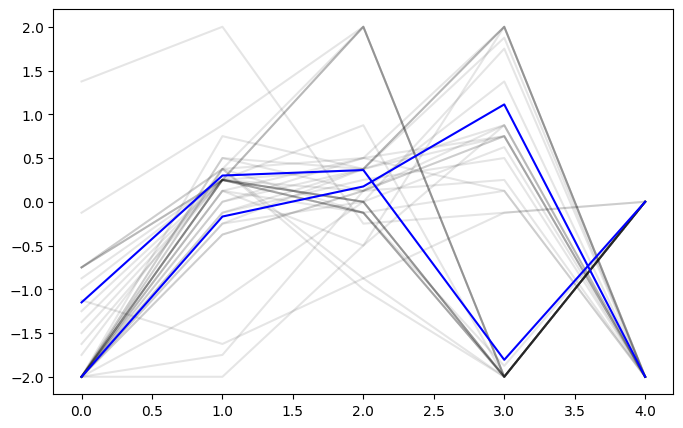

KeyboardInterrupt: 

In [7]:
from torch import autocast
from contextlib import nullcontext
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

for ORDER in [3]:
    for NFE in [5, 10, 15, 20, 25, 30, 35, 40]:
        for number in range(20):
            index = np.random.randint(0, N, size=(M,))
            prompts = list(prompts_list[index])
            x_T = x_T_list[index].to(device)
            x_0 = x_0_list[index].to(device)
            precision_scope = autocast if opt.precision == "autocast" else nullcontext
            with torch.no_grad():
                with precision_scope("cuda"):
                    with model.ema_scope():
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(len(prompts) * [""])
                        c = model.get_learned_conditioning(prompts)
                        samples, _ = sampler.target_matching(
                            S=NFE,
                            shape=(4, 64, 64),
                            conditioning=c,
                            batch_size=len(prompts),
                            verbose=False,
                            unconditional_guidance_scale=SCALE,
                            unconditional_conditioning=uc,
                            eta=0,
                            x_T=x_T,
                            x_0=x_0,
                            order=ORDER,
                            number=number,
                            scale_dir=f'/data/ldm/scale{SCALE}'
                        )

        plt.figure(figsize=[8, 5])
        optimal_log_scales_list = []
        for number in range(20):
            np_data = np.load(f'/data/ldm/scale{SCALE}/NFE={NFE},p={ORDER},number={number}.npz')
            optimal_log_scales_list.append(np_data['optimal_log_scales'])
            plt.plot(np_data['optimal_log_scales'].T, color='black', alpha=0.1)

        optimal_log_scales_list = np.stack(optimal_log_scales_list, axis=0)
        optimal_log_scales = np.mean(optimal_log_scales_list, axis=0)
        np.savez(f'/data/ldm/scale{SCALE}/NFE={NFE},p={ORDER}.npz', optimal_log_scales=optimal_log_scales)
        np_data = np.load(f'/data/ldm/scale{SCALE}/NFE={NFE},p={ORDER}.npz')
        plt.plot(np_data['optimal_log_scales'].T, color='blue', alpha=1)
        plt.show()


                                